In [41]:
%run .\word_embedding.ipynb

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ganap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ganap\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ganap\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ganap\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'you': 1, 'i': 2, 'the': 3, 'a': 4, 'fuck': 5, 'to': 6, 'in': 7, 'and': 8, 'is': 9, 'of': 10, 'your': 11, 'are': 12, 'it': 13, 'for': 14, 'sorry': 15, 'my': 16, 'not': 17, 'ass': 18, 'this': 19, 'me': 20, 'can': 21, 'am': 22, 'do': 23, 'will': 24, 'what': 25, 'sir': 26, 'fucking': 27, 'kill': 28, 'that': 29, 'faggot': 30, 'please': 31, 'have': 32, 'yourself': 33, 'cunt': 34, 'computer': 35, 'so': 36, 'on': 37, 'video': 38, 'suck': 39, 'be': 40, 'go': 41, 'going': 42, 'with': 43, 'brother': 44, 'offfuck': 45, 'science': 46, 'up': 47, 'piece': 48, 'if': 49, 's': 50, 'or': 51, 'how': 52, 'college': 53, 'but': 54, 'fucksex': 55, 'yourselfgo': 56, 'get': 57, 'like': 58, 'about': 59, 'engineering': 60, 'shit': 61, 'bitch': 62, 'bro': 63, 'off': 64, 'm': 65, 'we': 66, 'nigger': 67, 'all': 68, 'no': 69, 'from': 70, 'penis': 71, 'tell': 72, 'as': 73, 'u': 74, 'fucker': 75, 'he': 76, 'want': 77, 'thanks': 78, 'good': 79, 'bitches': 80, 'cock': 81, 'thank': 82, 'wikipedia': 83, 'which': 84, 'coc

In [2]:
import numpy as np
import pickle,itertools
import matplotlib.pyplot as plt

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras import layers

In [3]:
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding,Dropout, LSTM, Bidirectional,Dense, Input, Flatten
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [67]:
# def build_model(hp):
#     model = Sequential()
#     model.add(Embedding(input_dim = vocab_size,
#               output_dim = EMBEDDING_DIM,
#               input_length = MAX_NB_WORDS,
#              ))
#     for i in range(hp.Int('num_layers',1 , 3)):
#         model.add(LSTM(units=hp.Int('units_' + str(i),
#                                             min_value=32,
#                                             max_value=256,
#                                             step=32),
#                                return_sequences=True,dropout=0.0, recurrent_dropout=0.0))
#     model.add(LSTM(units=hp.Int('lstm',
#                                             min_value=32,
#                                             max_value=256,
#                                             step=32),dropout=0.3, recurrent_dropout=0.0))
#     model.add(layers.Dense(5, activation='softmax'))
#     model.compile(
#         optimizer='adam',
#         loss='categorical_crossentropy',
#         metrics=['accuracy'])
#     return model

In [68]:
# tuner=RandomSearch(
#                           build_model,
#                           objective='val_loss',
#                           max_trials=3,
#                           executions_per_trial=1,
#                           overwrite=True,
#                           directory='output',
#                           project_name="sentiment_analytics")

In [69]:
# tuner.search_space_summary()

Search space summary
Default search space size: 0


In [70]:
# tuner.search(x_train, y_train,
#              epochs=40,
#              validation_data=(x_val, y_val))

Trial 1 Complete [00h 16m 23s]
val_loss: 1.2734133005142212

Best val_loss So Far: 1.2734133005142212
Total elapsed time: 00h 16m 23s
INFO:tensorflow:Oracle triggered exit


In [72]:
# tuner.results_summary()

Results summary
Results in output\sentiment_analytics
Showing 10 best trials
Trial summary
Hyperparameters:
default configuration
Score: 1.2734133005142212


In [73]:
# model=tuner.get_best_models(num_models=1)[0]

In [74]:
# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 127, 100)          4000000   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 4,080,905
Trainable params: 4,080,905
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Sequential

model=Sequential()
model.add(Embedding(input_dim = vocab_size,
              output_dim = EMBEDDING_DIM,
              input_length = MAX_NB_WORDS,
              weights = [embedding_matrix],
              trainable = False
             ))
# model.add(Bidirectional(LSTM(224,return_sequences=True,dropout=0.0, recurrent_dropout=0.0))) # 1 lstm layer with 100 neurons
# model.add(Bidirectional(LSTM(224,return_sequences=True,dropout=0.0, recurrent_dropout=0.0)))
# model.add(Bidirectional(LSTM(32,dropout=0.3, recurrent_dropout=0.0)))
model.add(LSTM(224,return_sequences=True,dropout=0.0, recurrent_dropout=0.0)) # 1 lstm layer with 100 neurons
model.add(LSTM(224,return_sequences=True,dropout=0.0, recurrent_dropout=0.0))
model.add(LSTM(200,dropout=0.3))
model.add(Dense(6, activation='softmax'))



In [19]:
# # Functional API

# sequence_input =Input(shape=(maxlen,), dtype='int32')
# # static channel

# # non-static channel
# embedding_layer_train = Embedding(MAX_NB_WORDS,
#                             EMBEDDING_DIM,
#                             weights=[embedding_matrix],
#                             input_length=maxlen,
# #                             trainable=True
#                                  )
# embedded_sequences_train = embedding_layer_train(sequence_input)
# lstm1 = Bidirectional(LSTM(100,return_sequences=True,dropout=0.0, recurrent_dropout=0.0))(embedded_sequences_train)
# lstm2 = Bidirectional(LSTM(200,return_sequences=True,dropout=0.0, recurrent_dropout=0.0))(lstm1)
# lstm3 = Bidirectional(LSTM(200,dropout=0.3, recurrent_dropout=0.0))(lstm2)
# preds = Dense(5, activation='softmax')(lstm3)
# model = Model(sequence_input, preds)

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 200)          2229200   
                                                                 
 lstm_2 (LSTM)               (None, 300, 224)          380800    
                                                                 
 lstm_3 (LSTM)               (None, 300, 224)          402304    
                                                                 
 lstm_4 (LSTM)               (None, 200)               340000    
                                                                 
 dense_2 (Dense)             (None, 6)                 1206      
                                                                 
Total params: 3,353,510
Trainable params: 1,124,310
Non-trainable params: 2,229,200
_________________________________________________________________


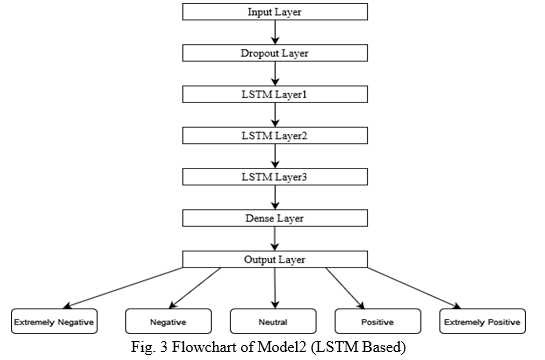

In [22]:
# from keras import callbacks
# earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
#                                         mode ="min", patience = 5, 
#                                         restore_best_weights = True)

# model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
#           epochs=100, batch_size=128, callbacks =[earlystopping])

model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=100, batch_size=128)


Epoch 1/100
54/54 [==============================] - 21s 315ms/step - loss: 1.7943 - accuracy: 0.1728 - val_loss: 1.7867 - val_accuracy: 0.1690
Epoch 2/100
54/54 [==============================] - 16s 298ms/step - loss: 1.7837 - accuracy: 0.1759 - val_loss: 1.7811 - val_accuracy: 0.1705
Epoch 3/100
54/54 [==============================] - 16s 304ms/step - loss: 1.7809 - accuracy: 0.1753 - val_loss: 1.7811 - val_accuracy: 0.1705
Epoch 4/100
54/54 [==============================] - 16s 306ms/step - loss: 1.7796 - accuracy: 0.1675 - val_loss: 1.7808 - val_accuracy: 0.1693
Epoch 5/100
54/54 [==============================] - 16s 302ms/step - loss: 1.8442 - accuracy: 0.1794 - val_loss: 1.7812 - val_accuracy: 0.1684
Epoch 6/100
54/54 [==============================] - 16s 300ms/step - loss: 1.7593 - accuracy: 0.2104 - val_loss: 1.7442 - val_accuracy: 0.2264
Epoch 7/100
54/54 [==============================] - 16s 300ms/step - loss: 1.7511 - accuracy: 0.2154 - val_loss: 1.7442 - val_accuracy:

54/54 [==============================] - 16s 300ms/step - loss: 0.5587 - accuracy: 0.8452 - val_loss: 0.7820 - val_accuracy: 0.7712
Epoch 58/100
54/54 [==============================] - 16s 301ms/step - loss: 0.4908 - accuracy: 0.8714 - val_loss: 0.7809 - val_accuracy: 0.7810
Epoch 59/100
54/54 [==============================] - 16s 300ms/step - loss: 0.4470 - accuracy: 0.8824 - val_loss: 0.7965 - val_accuracy: 0.7858
Epoch 60/100
54/54 [==============================] - 16s 300ms/step - loss: 0.4227 - accuracy: 0.8914 - val_loss: 0.7693 - val_accuracy: 0.7888
Epoch 61/100
54/54 [==============================] - 16s 300ms/step - loss: 0.4158 - accuracy: 0.8923 - val_loss: 0.8343 - val_accuracy: 0.7775
Epoch 62/100
54/54 [==============================] - 16s 301ms/step - loss: 0.4372 - accuracy: 0.8844 - val_loss: 0.8455 - val_accuracy: 0.7552
Epoch 63/100
54/54 [==============================] - 16s 300ms/step - loss: 0.4845 - accuracy: 0.8695 - val_loss: 0.8201 - val_accuracy: 0.773

In [23]:
model.save('comment_analysis.h5')

In [24]:
with open('log_history.pickle', 'wb') as f:
    pickle.dump(model_log.history, f, pickle.HIGHEST_PROTOCOL)

In [25]:
model = load_model("comment_analysis.h5")

In [26]:
classes = ["Happy", "Question", "Request", "Inforamtion","Not Satisfied","Irrelevant"]

In [27]:
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)
confusion_matrix(Y_test, y_pred_class)

106/106 [==============================] - 5s 38ms/step


array([[546,  15,  10,  13,   5,  22],
       [ 13, 394,  53,  71,   2,  22],
       [ 15,  30, 480,  18,   0,   2],
       [ 16,  44,  19, 419,   7,  41],
       [  5,   9,   1,  18, 496,  23],
       [  3,  23,   3,  70,  12, 446]], dtype=int64)

In [28]:
print(classification_report(Y_test, y_pred_class, target_names=classes))

               precision    recall  f1-score   support

        Happy       0.91      0.89      0.90       611
     Question       0.77      0.71      0.74       555
      Request       0.85      0.88      0.86       545
  Inforamtion       0.69      0.77      0.73       546
Not Satisfied       0.95      0.90      0.92       552
   Irrelevant       0.80      0.80      0.80       557

     accuracy                           0.83      3366
    macro avg       0.83      0.83      0.83      3366
 weighted avg       0.83      0.83      0.83      3366



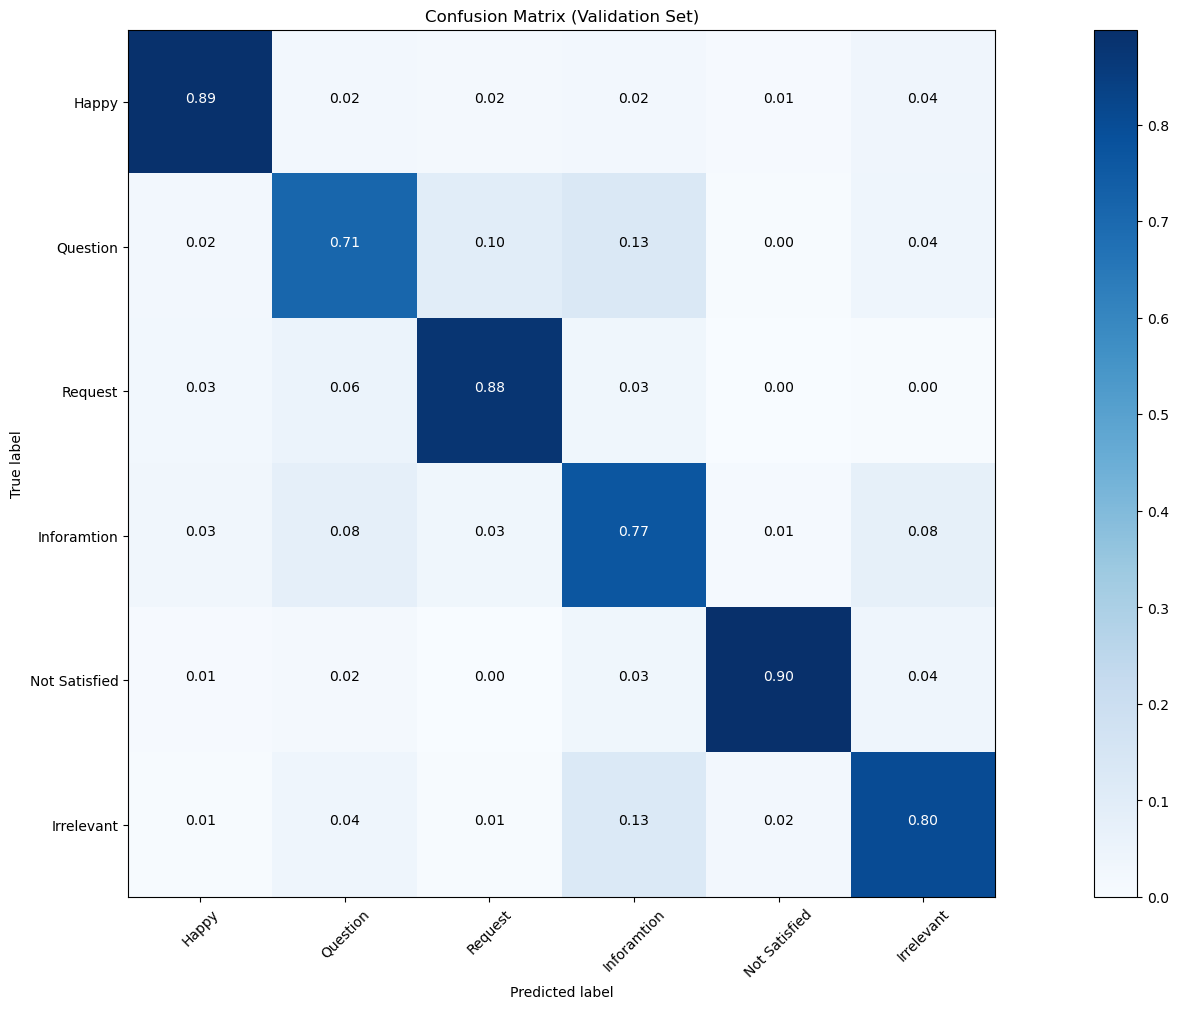

In [29]:
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)


In [30]:
x_train

array([[  26,  107,  239, ...,    0,    0,    0],
       [2124,   53,  155, ...,    0,    0,    0],
       [   9,    3, 1023, ...,    0,    0,    0],
       ...,
       [  37,  577,   35, ...,    0,    0,    0],
       [ 119, 2022, 3806, ...,    0,    0,    0],
       [2953,    3,  202, ...,    0,    0,    0]])

In [69]:
texts_input = ["anyways so my teacher was worried that i was gonna cry during the presentation but i didn t at the end of the da",
        "It bad fuck worst",
        "I am awesome",
        "I am good",
        "What a burden. Abit of a fail lunch with Dan",
        "dges our dissertation is due and the strike is coming worried",
        "angry",
       'I am not good','I am bad','I am not bad','I am worried','I am not worried','I am good','no good','no bad']



In [70]:
from googletrans import Translator


# text = 'seekiram sollu'
# text = 'neenga sanda podum pothum nee alaga irukinga'
# text = 'video massunga epidi shot pannuringa'
# text = 'enga vitulayum same samayal tha'
# text='padal varigal nalla iruku'
text="I've good"
# text='naan tha unga first viewer'
# text='ella videos vida unga video nalla iruku'
# text="sir kabhi start hoga"
# text="ellarukum oru, seat mathi"
# text="ohaiyo"
# text="ஊட்டி  மற்ற எல்லா இடங்களையும்  விட romba chill பகுதியாகும்"
# text="बच्चे TV देख रहे हैं"
# Detecting the language

def translate(text):
    translator = Translator()
    print(translator.detect(text))
    result = translator.translate(text).text
    

    possesions = {
        "aren't" : "are not",
        "can't" : "cannot",
        "couldn't" : "could not",
        "didn't" : "did not",
        "doesn't" : "does not",
        "don't": "do not",
        "hadn't" : "had not",
        "hasn't" : "has not",
        "haven't" : "have not",
        "he'd" : "he would",
        "he'll" : "he will",
        "he's" : "he is",
        "i'd" : "I would",
        "i'll" : "I will",
        "i'm" : "I am",
        "isn't" : "is not",
        "it's" : "it is",
        "it'll":"it will",
        "i've" : "I have",
        "let's" : "let us",
        "mightn't" : "might not",
        "mustn't" : "must not",
        "shan't" : "shall not",
        "she'd" : "she would",
        "she'll" : "she will",
        "she's" : "she is",
        "shouldn't" : "should not",
        "should've" : "should have",
        "that's" : "that is",
        "there's" : "there is",
        "they'd" : "they would",
        "they'll" : "they will",
        "they're" : "they are",
        "they've" : "they have",
        "we'd" : "we would",
        "we're" : "we are",
        "weren't" : "were not",
        "we've" : "we have",
        "what'll" : "what will",
        "what're" : "what are",
        "what's" : "what is",
        "what've" : "what have",
        "where's" : "where is",
        "who'd" : "who would",
        "who'll" : "who will",
        "who're" : "who are",
        "who's" : "who is",
        "who've" : "who have",
        "I've":"I have",
        "won't" : "will not",
        "wouldn't" : "would not",
        "would've" : "would have",
        "you'd" : "you would",
        "you'll" : "you will",
        "you're" : "you are",
        "you've" : "you have",
        "'re": " are",
        "wasn't": "was not",
        "we'll":" will",
        "must've": "must have",
        "y'all": "you all",
        "it'd ": "it would",
        "ain't": "is not",
        "ROFL":"Rolling on the floor laughing",
        "STFU":"Shut the freak up",
        "LMK":"Let me know",
        "ILY":"I love you",
        "YOLO":"You only live once",
        "SMH":"Shaking my head",
        "LMFAO":"Laughing my freaking ass off",
       "NVM":"Never mind",
        "IKR":"I know, right",
        "OFC":"Of course",
        "LOL":"Laughing Out Loud",
        "BRB":"Be Right Back",
        "BBL":"Be Back Later",
        "ASAP":"As Soon As Possible",
        "B4":"Before",
        "B4N":"Bye For Now",
        "BTW":"By The Way",
        "B/C":"Because",
        "C U L8R":"See You Later",
        "Def":"Definitely",
        "tmrw":"Tomorrow",
        "ETA":"Estimated Time of Arrival",
        "F2F":"Face To Face",
        "GF":"Girlfriend",
        "BF":"Boyfriend",
        "BFF":"Best Friend Forever",
        "AML":"All My Love",
        "G2G":"Got To Go",
        "GTG":"Got To Go",
        "GR8":"Great",
        "IDK":"I Don’t Know",
        "IDC":"I Don’t Care",
        "JK":"Just Kidding",
        "K":"OK",
        "THX":"Thanks",
        "PLS":"Please",
        "TTYL":"Talk To You Later",
        "TMI":"Too Much Information",
        "CYE":"Check Your Email",
        "FYI":"For Your Information",
        "IMHO":"In My Honest Opinion",
        "BION":"Believe It Or Not",
        "BRT":"Be Right There",
        "Y":"Why?",
        "PCM":"Please Call Me",
        "IYKWIM":"If You Know What I Mean",
        "WYSIWYG":"What You See Is What You Get",
        "XOXO":"Hugs and Kisses",
        "4U":"I have a question for you",
        "<3":"Love/friendship",
        "121":"One to one",
        "2":"To",
        "2EZ":"Too easy",
        "2F4U":"Too fast for you",
        "2G2BT":"Too good to be true",
        "2M2H":"Too much to handle",
        "2NITE":"Tonight",
        "4":"For",
        "8L3W":"Eight letters, three words (I love you)",
        "ABT":"About",
        "ADDY":"Address",
        "ADMIN":"Administrator",
        "AKA":"Also known as",
        "ALOL":"Actually laughing out loud",
        "APP":"Application",
        "ASAP":"As soon as possible",
        "B2W":"Back to work",
        "B4":"Before",
        "BAE":"baby",
        "BAK":"Back at keyboard",
        "BAU":"Business as usual",
        "BBL":"Be back later",
        "BBS":"Be back soon",
        "BC":"Because",
        "BCNU":"Be seeing you",
        "BD":"Big deal",
        "BDAY":"Birthday",
        "BFF":"Best friends forever",
        "BFD":"Big freaking deal",
        "BFN":"Bye for now",
        "BIF":"Before I forget",
        "BLNT":"Better luck next time",
        "BOL":"Best of luck",
        "BR":"Best regards",
        "BRT":"Be right there",
        "BTDT":"Been there, done that",
        "BTW":"By the way",
        "BYOB":"Bring your own beer",
        "BYOC":"Bring your own computer",
        "BYOD":"Bring your own device",
        "BYTM":"Better you than me",
        "CHK":"Check",
        "CID":"Consider it done",
        "CLD":"Could",
        "CLK":"Click",
        "CMON":"Come on",
        "COB":"Close of business",
        "CRAY":"Crazy",
        "CRE8":"Create",
        "CU":"See you",
        "DBEYR":"Don’t believe everything you read",
       "DERP":"Meaning stupid or silly",
        "DGT":"Don’t go there",
        "DIY":"Do it yourself",
        "DKDC":"Don’t know, don’t care",
        "DL":"Download",
        "DM":"Direct message",
        "DQMOT":"Don’t quote me on this",
        "DUPE":"Duplicate",
        "EAK":"Eating at keyboard",
        "EOBD":"End of business day",
        "EOD":"End of day",
        "EOM":"End of message",
        "ETA":"Estimated time of arrival",
        "EZ":"Easy",
        "F2F":"Face to face",
        "FAQ":"Frequently asked questions",
        "FB":"Facebook",
        "FBM":"Fine by me",
        "FBOW":"For better or worse",
        "FF":"Follow Friday",
        "FIMH":"Forever in my heart",
        "FOAF":"Friend of a friend",
        "FOMO":"Fear of missing out",
        "FRT":"For real though",
        "FTBOMH":"From the bottom of my heart",
        F"TL":"For the loss",
        "FTW":"For the win",
        "FWB":"Friend with benefits",
        "FWIW":"For what it’s worth",
        "FWM":"Fine with me",
       " FYA":"For your amusement",
        "FYEO":"For your eyes only",
        "4YEO":"For your eyes only",
        "FYI":"For your information",
        "G2CU":"Good to see you",
        "GB":"Goodbye",
        "GB2W":"Get back to work",
        "GD":"Good",
        "GFI":"Go for it",
        "GL":"Good luck",
        "GOI":"Get over it",
        "GR8":"Great",
        "GRATZ":"Congratulations",
        "H8":"Hate",
        "143":"I love you",
        "n8":"night",
        "w8":"what",
        "msg":"message",
        "u":"you",
        "b/w":"between",
        "lyk":"like",
        "luv":"love",
        "bro":"brother",
        "sis":"sister",
        "nyc":"nice",
        "gm":"good morning",
        "gn":"good night",
        "sd":"sweet dreams",
        "tc":"take care",
        "4ever":"forever",
        "tq":"thank you",
        "wp":"whatsapp",
        "fb":"facebook",
        "wth":"what the hell",
        "wtf":"what the fuck",
        "Utube":"Youtube",
        "ig":"instagram",
        "info":"information",
        "govt":"government",
        "clg":"college",
        "scl":"school",
        "hbd":"happy birthday",
        "R":"are",
        "cum":"come",
        "bcoz":"because",
        "bc":"busy",
        "eve":"evening",
       "s":"yes",
        "2day":"today",
        "ss":"screenshot",
        "wat":"what",
        "whr":"where",
        "Yday":"Yesterday",
        "Ur":"your",
        "frnd":"friend",
        "loml":"love of my life",
       "ttys":"Talk To You soon",
        "tqsm":"thank you so much",
        "omg":"oh my god",
        "osm":"owesome",
        
    }
    result = " ".join(possesions.get(ele, ele) for ele in result.split())
    return result

In [71]:
corpus_text = []
for i in range(0, len(texts_input)):
    soup = BeautifulSoup(texts_input[i],features="html.parser")
    text=translate(soup.get_text('\n'))
    print(i)
    review = text.split()
    review= [word for word in review if not word.startswith('@') ]
    review = ' '.join(review)
    
    review = re.sub('[^a-zA-Z]', ' ',review)
    review = review.lower()
    
    review = word_tokenize(review)
    final=[]
    for word in review:
         if word.endswith("'t"):
            word='not'
         final.append(word)
#          if word not in stopwords:
#             final.append(word)
#          else:
#             final.append(ps.stem(word))
#             final.append(wl.lemmatize(word,pos='v'))
    
    final = ' '.join(final)
    print(texts_input[i])
    print(text)
    print(final)
    corpus_text.append(final)

Detected(lang=en, confidence=1)
0
anyways so my teacher was worried that i was gonna cry during the presentation but i didn t at the end of the da
anyways so my teacher was worried that i was gonna cry during the presentation but i didn t at the end of the da
anyways so my teacher was worried that i was gon na cry during the presentation but i didn t at the end of the da
Detected(lang=en, confidence=1)
1
It bad fuck worst
It bad fuck worst
it bad fuck worst
Detected(lang=en, confidence=1)
2
I am awesome
I am awesome
i am awesome
Detected(lang=en, confidence=1)
3
I am good
I am good
i am good
Detected(lang=en, confidence=1)
4
What a burden. Abit of a fail lunch with Dan
What a burden. Abit of a fail lunch with Dan
what a burden abit of a fail lunch with dan
Detected(lang=en, confidence=1)
5
dges our dissertation is due and the strike is coming worried
dges our dissertation is due and the strike is coming worried
dges our dissertation is due and the strike is coming worried
Detected(lang

In [84]:
corpus_text

['anyways so my teacher was worried that i was gon na cry during the presentation but i didn t at the end of the da',
 'it bad fuck worst',
 'i am awesome',
 'i am good',
 'what a burden abit of a fail lunch with dan',
 'dges our dissertation is due and the strike is coming worried',
 'angry',
 'i am not good',
 'i am bad',
 'i am not bad',
 'i am worried',
 'i am not worried',
 'i am good',
 'no good',
 'no bad']

In [74]:
with open('data.pickle', 'rb') as f:
    corpus_test_fit = pickle.load(f)
    
corpus_test_fit

['Wooow i start learning and first listen about this channel in start my way in dev good practice Dave Malone',
 'Sir America under great crisis is it safe for choosing computer engineering for IT jobs',
 'Thank you so much',
 'Oh Great All the best brother',
 'How many OSM he ye yaar',
 'love how it ends with printers',
 'Prajakta Di you are the biggest inspiration to me I can not tell you how much your positivity and hardwork have influenced me you have affected my life in a very positive way so many good things happening to me since I have started following you Thanks a lot for that and keep shining as always',
 'BBA and computer science in these which is the best one carrier option Please reply my comment sir',
 'hey I am years old and want to find a job in tech would you recommend me to do a software development apprenticeship where i work and learn on the job or do a computer science degree since you are saying it is mainly theory i want to be done with school As soon as possible

In [91]:
token_test = Tokenizer()
token_test.fit_on_texts(corpus_test_fit)
sequences_test = token_test.texts_to_sequences(corpus_text)
word_index_test=token_test.word_index
print(word_index_test)

{'you': 1, 'i': 2, 'the': 3, 'a': 4, 'fuck': 5, 'to': 6, 'in': 7, 'and': 8, 'is': 9, 'of': 10, 'your': 11, 'are': 12, 'it': 13, 'for': 14, 'sorry': 15, 'my': 16, 'not': 17, 'ass': 18, 'this': 19, 'me': 20, 'can': 21, 'am': 22, 'do': 23, 'will': 24, 'what': 25, 'sir': 26, 'fucking': 27, 'kill': 28, 'that': 29, 'faggot': 30, 'please': 31, 'have': 32, 'yourself': 33, 'cunt': 34, 'computer': 35, 'so': 36, 'on': 37, 'video': 38, 'suck': 39, 'be': 40, 'go': 41, 'going': 42, 'with': 43, 'brother': 44, 'offfuck': 45, 'science': 46, 'up': 47, 'piece': 48, 'if': 49, 's': 50, 'or': 51, 'how': 52, 'college': 53, 'but': 54, 'fucksex': 55, 'yourselfgo': 56, 'get': 57, 'like': 58, 'about': 59, 'engineering': 60, 'shit': 61, 'bitch': 62, 'bro': 63, 'off': 64, 'm': 65, 'we': 66, 'nigger': 67, 'all': 68, 'no': 69, 'from': 70, 'penis': 71, 'tell': 72, 'as': 73, 'u': 74, 'fucker': 75, 'he': 76, 'want': 77, 'thanks': 78, 'good': 79, 'bitches': 80, 'cock': 81, 'thank': 82, 'wikipedia': 83, 'which': 84, 'coc

In [92]:
len(sequences_test)

15

In [93]:

data_test = pad_sequences(sequences_test, padding='post', maxlen=300)
print(len(data_test))

15


In [94]:

# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

# sequences_test = tokenizer.texts_to_sequences(corpus_test)

# data_test = pad_sequences(sequences_test, padding='post', maxlen=maxlen)
# y_prob = model.predict(data_test)
# print( np.argmax(y_prob[2]))
# for n, prediction in enumerate(y_prob):
#     pred = np.argmax(y_prob,axis=1)[n]
#     print(text[n],"\nPrediction:",classes[pred],"\n")
# print(tokenizer.sequences_to_texts(data_test))

In [95]:
# onehot_test=[one_hot(words,MAX_NB_WORDS)for words in corpus_test] 

In [96]:
# embedded_docs=pad_sequences(onehot_test,padding='pre',maxlen=maxlen)
# print(embedded_docs)

In [97]:
# data_test=np.array(embedded_docs)
# data_test

In [98]:
y_pred = model.predict(data_test)
y_pred_class = np.argmax(y_pred,axis=1)
value=np.argmax(y_pred,axis=1)
for n, prediction in enumerate(y_pred):
    pred = np.argmax(y_pred,axis=1)[n]
    print(texts_input[n],"\nPrediction:",classes[pred],"\n")
print(len(value))


1/1 [==============================] - 0s 55ms/step
anyways so my teacher was worried that i was gonna cry during the presentation but i didn t at the end of the da 
Prediction: Irrelevant 

It bad fuck worst 
Prediction: Not Satisfied 

I am awesome 
Prediction: Happy 

I am good 
Prediction: Happy 

What a burden. Abit of a fail lunch with Dan 
Prediction: Question 

dges our dissertation is due and the strike is coming worried 
Prediction: Inforamtion 

angry 
Prediction: Not Satisfied 

I am not good 
Prediction: Happy 

I am bad 
Prediction: Irrelevant 

I am not bad 
Prediction: Irrelevant 

I am worried 
Prediction: Irrelevant 

I am not worried 
Prediction: Irrelevant 

I am good 
Prediction: Happy 

no good 
Prediction: Happy 

no bad 
Prediction: Inforamtion 

15


In [32]:
with open('log_history.pickle', 'rb') as f:
    log = pickle.load(f)

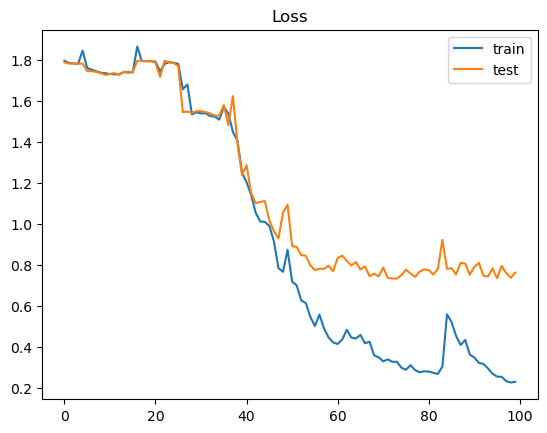

In [33]:
plt.title('Loss')
plt.plot(log['loss'], label='train')
plt.plot(log['val_loss'], label='test')
plt.legend()
plt.show();

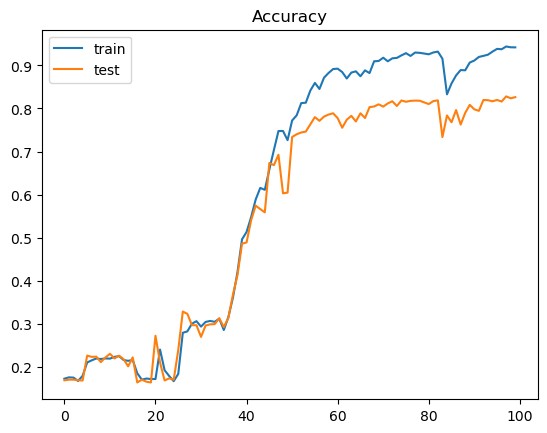

In [34]:
plt.title('Accuracy')
plt.plot(log['accuracy'], label='train')
plt.plot(log['val_accuracy'], label='test')
plt.legend()
plt.show();

In [2]:
# plt.title('Accuracy')
# plt.plot(model_log.history['accuracy'], label='train')
# plt.plot(model_log.history['val_accuracy'], label='test')
# plt.legend()
# plt.show();